# Computational Design of Microbial Communities - part 2

The tools of molecular biology have given us the ability to engineer cells to behave in explicitly defined ways. With these tools, we are interested in creating new microbiomes; collections of cells that interact to form a self-regulating community. With this ability we can not just explore ecological questions, but also create functional communities for a variety of applications, such as more efficient bio-industrial processes.

To engineer a collection of strains to from a self-regulating community, we can engineer how they interact with each other. In the lab this involves the introduction or removal of genetic components that infer the capability to produce or consume molecules that can affect growth and survival. 

Using the gLV model we presented in part 1, engineering interactions involves the tweaking of model parameters - particularly those in the interaction matrix $A$. If we have a definable goal for our community, the design challenge is to find the parameters that allow the model to meet that goal.

The goals we set can be anything that is mathematically definable. In our work, we are mowstly interested in communities that produce stable coexistence of all members, and ideally defined population levels. In previous work we have also explored oscillations and chaos. 

## Approximate Bayesian Computation

Aproximate Bayesian Computation (ABC) is a computational approach for parameter fitting (and model selection as we will see later). It works by repeatedly sampling and simulating models to produce an approximation of the posterior distribution. This is normally used for parameter estimation given some data, but it can be applied to any scenario in which we can estimate how close a simulation is to some desired behaviour.

We are going to start simple, using gLV with two species to find how to create communities with stable co-existence. To do this with ABC we need four things:
1. A model to simulate
2. A set of prior distributions for each of the parameters in the model
3. A distance function that produces a measure of how close we are to our desired behaviour
4. A threshold for how close we need to be to our objective to accept the result

### 1. The Model

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import Callable, Union
from IPython.display import clear_output
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class GLVModel:
    """
    Generalized Lotka-Volterra model
    """
    def __init__(self, 
                 num_species: int, 
                 timepoints: np.ndarray, 
                 params: dict = None):
        self.timepoints = timepoints  # Time points for simulation
        self.num_species = num_species  # Number of species in the model
                
        # Set all parameters to 0 if none are provided
        if params is None:
            self.params = {
                "y0": np.zeros(self.num_species),
                "r": np.zeros(self.num_species),
                "A": np.zeros((self.num_species, self.num_species))
            }
        else:
            # if we have y0, r and A, assume we have been given full parameters
            if 'y0' in params.keys() and 'r' in params.keys() and 'A' in params.keys():
                self.params = params
            # otherwise, assume we have been given parameters in the form r_1, A_12 etc, that need reshaping 
            # (this allows us to pass in a subset of parameters to fix)
            else:
                self.params = {
                    'y0': np.zeros(self.num_species),
                    "r": np.zeros(self.num_species),
                    "A": np.zeros((self.num_species, self.num_species))
                }
                self.params = self._reshape_params(params)

    def _step(self, t, y, params):
        """
        Compute the derivatives for the gLV model.
        """ 
        r = params["r"]  # Growth rates (num species,)
        A = params["A"]  # Interaction matrix (num species, num species)
        # y  # Population values (num species,)

        dydt = (r + np.dot(A, y)) * y

        return dydt
    
    def simulate(self, params: dict) -> dict:
        """
        Simulate the model with the given parameters.
        """
        self.params = self._reshape_params(params)

        result = solve_ivp(self._step, 
                           t_span=[0, self.timepoints[-1]], 
                           y0=self.params["y0"], 
                           args=(self.params,), 
                           method='LSODA',  
                           t_eval=self.timepoints,
                           min_step=1e-3
                           )
        
        # Check if integration was successful
        if not result.success:
            return {"success": False}

        # Check for numerical issues
        if np.any(np.isnan(result.y)) or np.any(np.isinf(result.y)):
            return {"success": False}

        return {"success": True, "t": result.t, "y": result.y}

    def _reshape_params(self, params: dict) -> dict:
        """
        Incoming params dictionary has parameters with keys such as 'r_1', 'A_12' etc. This function reshapes them into vectors and matrices as appropriate.
        """
        reshaped_params = self.params.copy()
        for key in params.keys():
            if key.startswith('A_'):
                i, j = map(int, key[2:])
                reshaped_params['A'][i-1, j-1] = params[key]
            else:
                key_base, idx = key.rsplit('_', 1)
                idx = int(idx) - 1
                reshaped_params[key_base][idx] = params[key]

        return reshaped_params


### 2. The prior distributions

In [3]:
def create_glv_priors(num_species: int = 2) -> dict:
    """
    Create a prior distribution for the gLV model parameters.
    num_species: number of species in the model
    Returns:
        dict: dictionary containing details for prior distribution of the model parameters
    """
    prior = {}
    for i in range(num_species):
        prior[f'y0_{i+1}'] = {'type': 'uniform', 'args': (0, 2)}  # note the uniform args in scipt.stats are loc and scale, equivalent to min and (max-min)
        prior[f'r_{i+1}'] = {'type': 'uniform', 'args': (-1, 2)}
        for j in range(num_species):
            prior[f'A_{i+1}{j+1}'] = {'type': 'uniform', 'args': (-1, 2)}

    return prior

### 3. The distance function

In [4]:
def distance_function(simulated_data: dict, target_data: dict = None) -> float:
    """
    Compute the aggregated distance between simulated and an objective.
    simulated_data: dict with keys 'success', 't', 'y' from model.simulate()
    target_data: not used here, but could be used to compare to real data or target objectives
    Returns:
        float: distance metric
    """
    
    if simulated_data is None:
        raise ValueError("No simulated data provided")

    # If simulation failed or produced invalid data, return infinite distance
    if simulated_data['success'] is False:
        return np.inf    
    if np.any(simulated_data['y']) < 0:
        return np.inf
    

    distance = 0
    # for each species, calculate distance components
    for i in range(simulated_data['y'].shape[0]):
        # If a species goes extinct, return infinite distance
        final_population = simulated_data['y'][i, -1]
        if final_population <= 0:
            return np.inf
        elif target_data is not None:
            distance += (final_population - target_data['final_population'][i])**2 # squared difference to target final population
        
        # If the population is alive, check that it is stable i.e. minimise final gradient
        gradient = (simulated_data['y'][i, -1] - simulated_data['y'][i, -2]) / (simulated_data['t'][-1] - simulated_data['t'][-2])
        distance += abs(gradient)

    return distance

### 4. Threshold

Given our distance is an aggregated distance (i.e. the sum of multiple distances) our threshold will be a single value (which we will just set below)

## The ABC rejection algorithm

1. Sample model parameters from the prior distributions; we call this model + parameters a particle
2. Simulate the particle
3. Compute the distance between simulated data and the objective
4. Check if the distance is within the acceptance threshold; accept the particle if it is below the threshold and discard otherwise

The posterior distribution is then given by the distribution of accepted particles

In [5]:
class ABCRejection:
    """
    Approximate Bayesian Computation using Rejection Sampling
    """
    def __init__(self, 
                 model: Callable, 
                 parameter_priors:  dict, 
                 distance_function: Callable,
                 threshold: float,
                 target_data: dict = None,
                 acceptor: Callable = None,
                 population_size: int = 100):
        
        self.model = model
        self.parameter_priors = parameter_priors       
        self.distance_function = distance_function
        self.threshold = threshold
        self.target_data = target_data
        self.population_size = population_size
        

        if acceptor is None:
            self.acceptor = lambda x: np.less(x, self.threshold)
        else:
            self.acceptor = acceptor

        self.accepted_particles = []

    def _sample_param(self, prior: dict) -> Union[float, int]:
        """
        Sample a parameter from its prior distribution.
        """
        if prior["type"] == "uniform":
            return stats.uniform.rvs(prior["args"][0], prior["args"][1])
        elif prior["type"] == "normal":
            return stats.norm.rvs(prior["args"][0], prior["args"][1])
        else:
            raise ValueError(f"Unknown distribution type: {prior['type']}")

    def run(self):
        """
        Run the ABC Rejection Sampling algorithm.
        """
        num_sampled = 0
        while len(self.accepted_particles) < self.population_size:
            num_sampled += 1
            # 1. Sample parameters
            parameters = {}
            for param, prior in self.parameter_priors.items():
                parameters[param] = self._sample_param(prior)

            # 2. Simulate the sampled model with sampled parameters
            simulated_data = self.model(parameters)

            # 3. Compute the distance between simulated data and target data
            distance = self.distance_function(simulated_data, self.target_data)

            # 4. Check if the distance is within the acceptance threshold
            if self.acceptor(distance):
                self.accepted_particles.append((parameters, distance))
                # update status
                clear_output(wait=True)
                print(f"attempted: {num_sampled}, accepted: {len(self.accepted_particles)}")
            
            if num_sampled % 1000 == 0:  # every 1000 samples, print status
                clear_output(wait=True)
                print(f"attempted: {num_sampled}, accepted: {len(self.accepted_particles)}")

        return self.accepted_particles


### Put it all together
So now we have the components for running ABC on the gLV model, let's put them together and see what happens

In [6]:
# Setup a model
num_species = 2
simulation_timepoints = np.linspace(0, 50, 51)
model = GLVModel(num_species=2, 
                 timepoints=simulation_timepoints
                 )

# Setup prior distributions
prior = create_glv_priors(num_species=num_species)

# Setup ABC Rejection
abc = ABCRejection(
    model=model.simulate,
    parameter_priors=prior,
    distance_function=distance_function,
    threshold=2,  # Adjust thresholds as needed
    population_size=100,
    target_data={'final_population': [3.0, 5.0]}  # Example target data
)

# Run ABC Rejection
posterior = abc.run()

attempted: 79137, accepted: 100


### Visualising the posterior distributions

In [ ]:
def _particle_list_to_dataframe(particle_list: list) -> pd.DataFrame:
    """
    Convert a list of particles into a pandas DataFrame.
    """
    data = []
    for parameters_dict, distances in particle_list:
        row = {'distances': distances}
        row.update(parameters_dict)
        data.append(row)
    return pd.DataFrame(data)

def plot_posteriors_1D(accepted_particles: Union[list, pd.DataFrame]):
    """
    Plot 1D posterior KDE for each parameter.
    accepted_particles: a list of tuples (model_idx, parameters_dict, distances)
    """
    if isinstance(accepted_particles, list):
        # convert accepted particles into a dataframe for easier plotting
        df = _particle_list_to_dataframe(accepted_particles)
    else:
        df = accepted_particles

    # create 1D density plots for each parameter - multi-panel figure - number of panels depends on number of parameters
    plt.figure(figsize=(10, int(len(df.columns) * 2)))
    for i, param in enumerate(df.columns):
        if param not in ["distances"]:
            plt.subplot(len(df.columns) - 1, 3, i)
            sns.kdeplot(df[param], bw_adjust=0.5)
            # plt.title(f"{param} posterior")
            plt.xlabel(param)
            plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


def plot_posteriors_2D(accepted_particles: Union[list, pd.DataFrame]):
    """
    Plot 2D posterior pair plots for all parameters.
    accepted_particles: a list of tuples (model_idx, parameters_dict, distances)
    """
    if isinstance(accepted_particles, list):
        # convert accepted particles into a dataframe for easier plotting
        df = _particle_list_to_dataframe(accepted_particles)
    else:
        df = accepted_particles

    # create pairs plots of the parameters
    sns.pairplot(df,
                 vars=df.columns.difference(["distances"]),
                 diag_kind='kde',
                 plot_kws={'alpha': 0.2},
                 height=1.5                
                 )
    plt.show()


We can look at the posterior distributions of each parameter to see how constrained they are for our objective. Some parameters have no constraint within our prior bounds e.g. $y0$, whereas some are more tightly constrained (e.g. $A_{11}$)

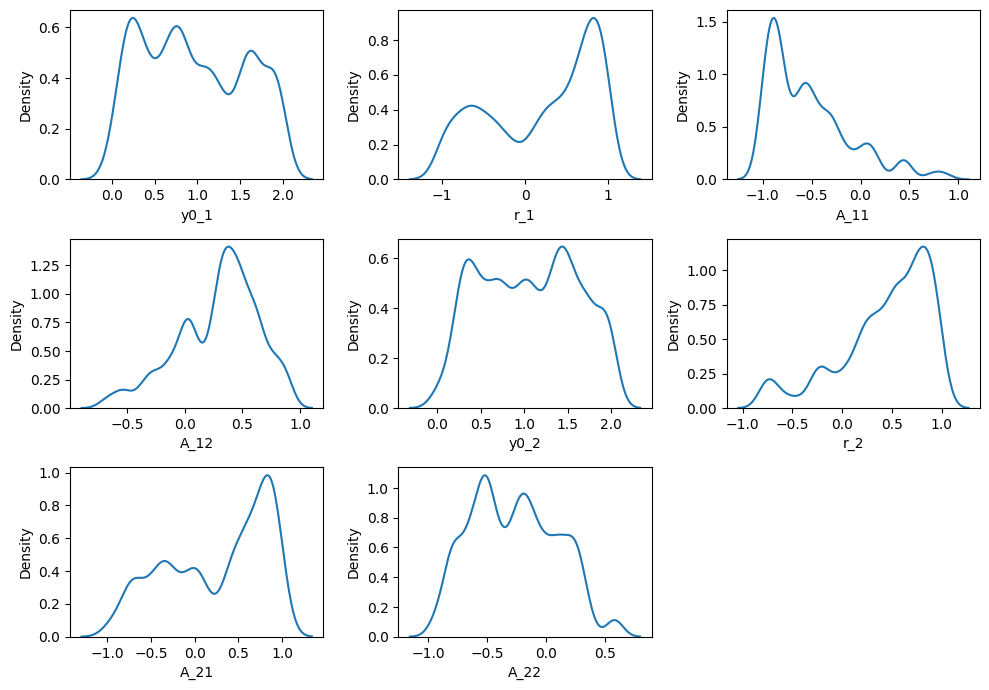

In [ ]:
posteriors_df = _particle_list_to_dataframe(posterior)
plot_posteriors_1D(posteriors_df)

However, if we plot the joint distribution of parameters, we can see that many parameters are correlated. In reality the posterior distribution forms a shape with a number of dimensions given by the number of parameters.

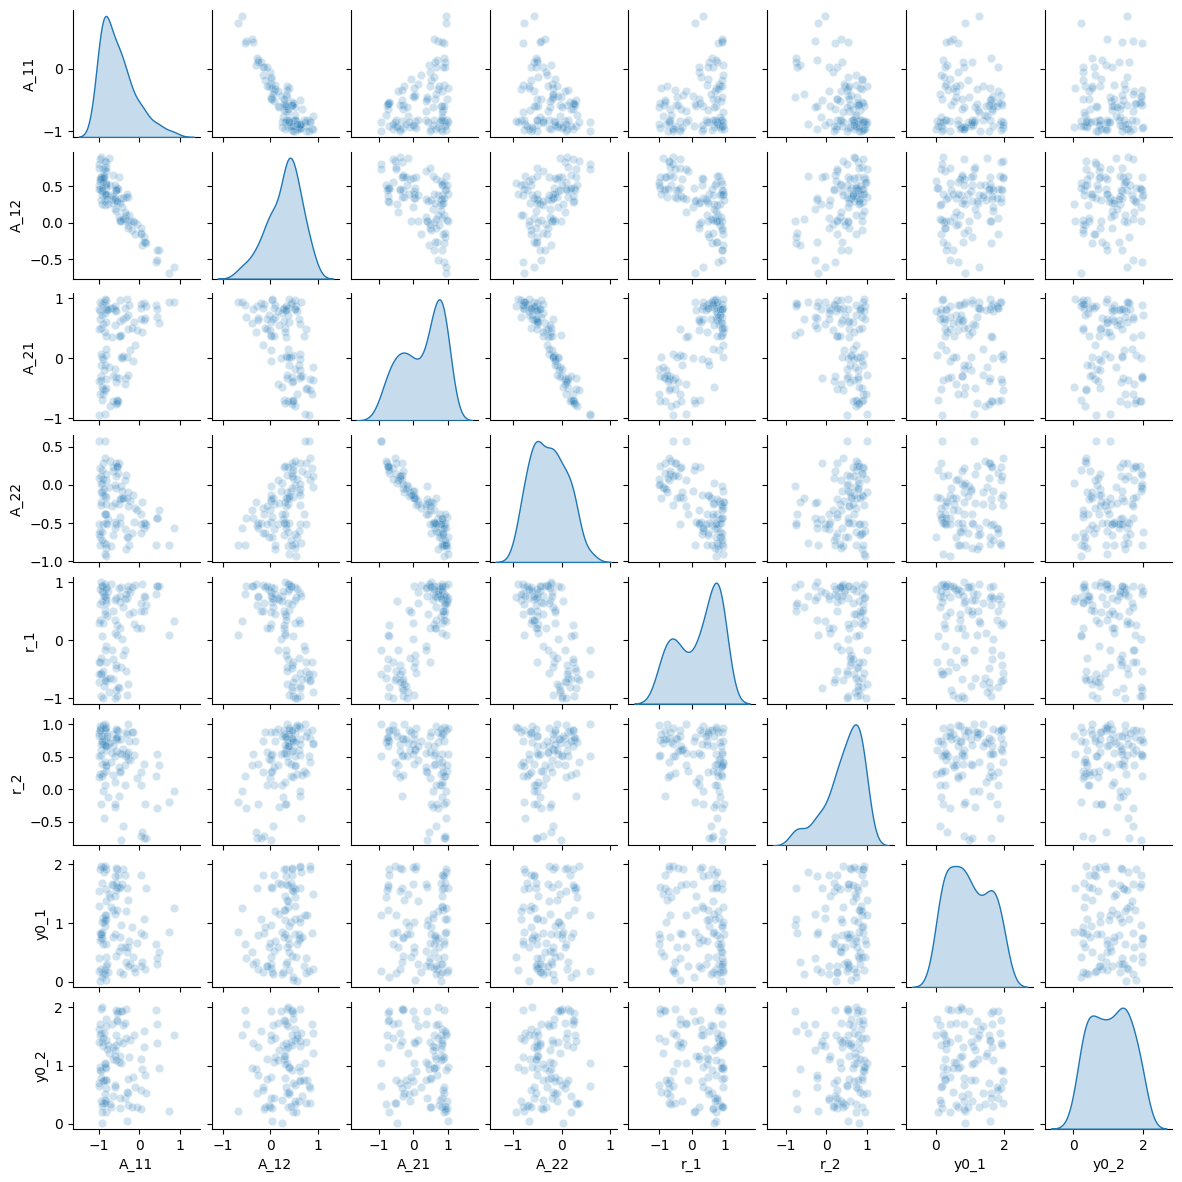

In [ ]:
plot_posteriors_2D(posteriors_df)

And we can look at a sample of the trajectories of the accepted particles to see how they behave dynamically.

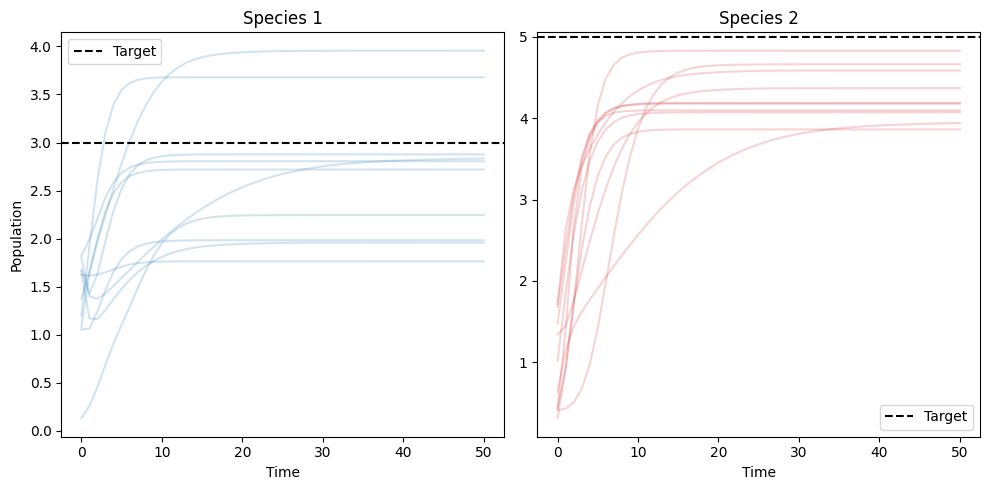

In [ ]:
# plot a sample of trajectories from the accepted particles
n_plot = min(10, len(posterior))
sample_indices = np.random.choice(len(posterior), size=n_plot, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx in sample_indices:
    params, dist = posterior[idx]
    sim_data = model.simulate(params)

    axes[0].plot(sim_data['t'], sim_data['y'][0], color='tab:blue', alpha=0.2)
    axes[1].plot(sim_data['t'], sim_data['y'][1], color='tab:red', alpha=0.2)

# Add horizontal lines at target final population
axes[0].axhline(3.0, color='k', linestyle='--', label='Target')
axes[1].axhline(5.0, color='k', linestyle='--', label='Target')

axes[0].set_title('Species 1')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[1].set_title('Species 2')
axes[1].set_xlabel("Time")

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

But it is perhaps more useful to look at the mean and 95% confidence intervals. 

You can see here that CI's around the target are pretty wide. We can tighten this by reducing the acceptance threshold but this will come at the expense of having to simulate and reject more particles.

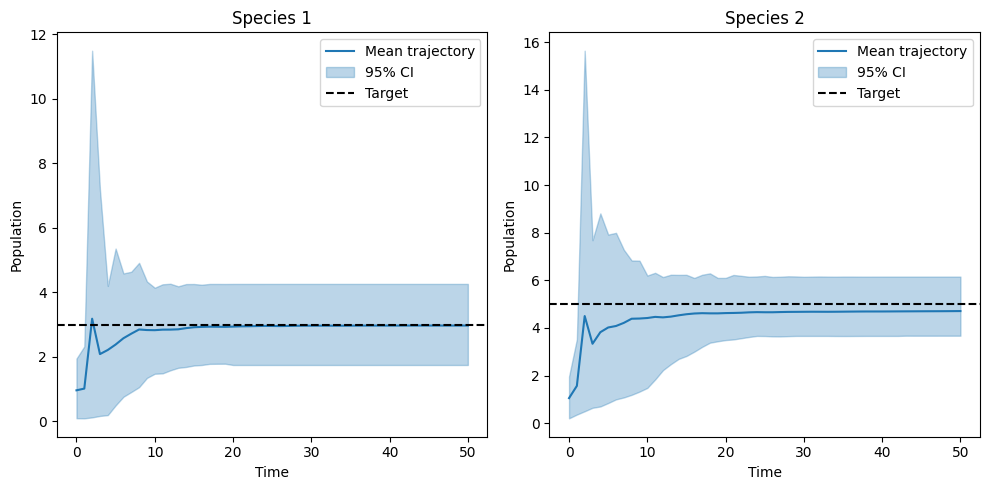

In [ ]:
# Collect all successful trajectories
all_trajectories = []
for params, dist in posterior:
    sim_data = model.simulate(params)
    if sim_data.get("success", False):
        all_trajectories.append(sim_data["y"])

if not all_trajectories:
    raise ValueError("No successful simulations found.")

# Convert to numpy array: shape (n_particles, n_species, n_timepoints)
all_trajectories = np.array(all_trajectories)  # shape: (N, 2, T)
n_species = all_trajectories.shape[1]
t = sim_data["t"]

fig, axes = plt.subplots(1, n_species, figsize=(10, 5), sharex=True)

for i in range(n_species):
    species_traj = all_trajectories[:, i, :]  # shape: (N, T)
    mean_traj = np.mean(species_traj, axis=0)
    lower = np.percentile(species_traj, 2.5, axis=0)
    upper = np.percentile(species_traj, 97.5, axis=0)

    ax = axes[i] if n_species > 1 else axes
    ax.plot(t, mean_traj, color='C0', label='Mean trajectory')
    ax.fill_between(t, lower, upper, color='C0', alpha=0.3, label='95% CI')
    ax.set_title(f"Species {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")

    # Add target line if desired
    if i == 0:
        ax.axhline(3.0, color='k', linestyle='--', label='Target')
    elif i == 1:
        ax.axhline(5.0, color='k', linestyle='--', label='Target')

    ax.legend()

plt.tight_layout()
plt.show()

In [25]:
# import pandas as pd
# p_df = pd.DataFrame(posterior, columns=["model_idx", "parameters", "distances"])
# # write dataframe to csv
# p_df.to_csv("../data/glv_abc_rejection_10000.csv", index=False)

# # expand parameters column
